In [ ]:
  # === STEP 1: Mount Google Drive and Download/Extract MS COCO train2017 ===
from google.colab import drive
import os, shutil, zipfile, requests, random
from PIL import Image

drive.mount('/content/drive')

Mounted at /content/drive


In [ ]:

drive_dataset_path = "/content/drive/MyDrive/train2017.zip"
local_zip_path = "/content/train2017.zip"
extract_folder = "/content/train2017"
extract_path = os.path.join(extract_folder, "train2017")

In [ ]:
# Download if not in Drive
if not os.path.exists(drive_dataset_path):
    print("⬇️ Downloading MS COCO train2017.zip to Drive...")
    url = "http://images.cocodataset.org/zips/train2017.zip"
    response = requests.get(url, stream=True)
    with open(drive_dataset_path, "wb") as f:
        for chunk in response.iter_content(chunk_size=1024*1024):
            if chunk:
                f.write(chunk)
    print("✅ Download complete!")

⬇️ Downloading MS COCO train2017.zip to Drive...
✅ Download complete!


In [ ]:
if not os.path.exists(local_zip_path):
    shutil.copy(drive_dataset_path, local_zip_path)
    print("✅ Copied zip to Colab.")
else:
    print("⚠️ Zip already exists locally.")


✅ Copied zip to Colab.


In [ ]:
if not os.path.exists(extract_path):
    with zipfile.ZipFile(local_zip_path, 'r') as zip_ref:
        zip_ref.extractall(extract_folder)
    print("✅ Dataset extracted.")
else:
    print("⚠️ Dataset already extracted.")

✅ Dataset extracted.


In [ ]:
all_images = [f for f in os.listdir(extract_path) if f.endswith('.jpg')]
print(f"📸 Total images in original dataset: {len(all_images)}")


📸 Total images in original dataset: 118287


In [ ]:
# === STEP 2: Prepare 20K images ===
subset_dir = "/content/train2017_subset_20k"
resized_dir = "/content/train2017_gan/class_b/class_x"

os.makedirs(subset_dir, exist_ok=True)
os.makedirs(resized_dir, exist_ok=True)


In [ ]:
sample_images = random.sample(all_images, 20000)

In [ ]:
for f in sample_images:
    shutil.copy(os.path.join(extract_path, f), os.path.join(subset_dir, f))

for f in os.listdir(subset_dir):
    try:
        im = Image.open(os.path.join(subset_dir, f)).convert("RGB")
        im = im.resize((64, 64))
        im.save(os.path.join(resized_dir, f))
    except:
        continue

print("✅ Prepared 20K resized images.")

✅ Prepared 20K resized images.


In [ ]:
# === STEP 3: Define GAN ===
import torch
import torch.nn as nn

class Generator(nn.Module):
    def __init__(self, latent_dim):
        super().__init__()
        self.model = nn.Sequential(
            nn.ConvTranspose2d(latent_dim, 512, 4, 1, 0, bias=False),
            nn.BatchNorm2d(512), nn.ReLU(True),
            nn.ConvTranspose2d(512, 256, 4, 2, 1, bias=False),
            nn.BatchNorm2d(256), nn.ReLU(True),
            nn.ConvTranspose2d(256, 128, 4, 2, 1, bias=False),
            nn.BatchNorm2d(128), nn.ReLU(True),
            nn.ConvTranspose2d(128, 64, 4, 2, 1, bias=False),
            nn.BatchNorm2d(64), nn.ReLU(True),
            nn.ConvTranspose2d(64, 3, 4, 2, 1, bias=False),
            nn.Tanh()
        )

    def forward(self, z):
        return self.model(z)

class Discriminator(nn.Module):
    def __init__(self):
        super().__init__()
        self.model = nn.Sequential(
            nn.Conv2d(3, 64, 4, 2, 1, bias=False), nn.LeakyReLU(0.2),
            nn.Conv2d(64, 128, 4, 2, 1, bias=False), nn.BatchNorm2d(128), nn.LeakyReLU(0.2),
            nn.Conv2d(128, 256, 4, 2, 1, bias=False), nn.BatchNorm2d(256), nn.LeakyReLU(0.2),
            nn.Conv2d(256, 512, 4, 2, 1, bias=False), nn.BatchNorm2d(512), nn.LeakyReLU(0.2),
            nn.Conv2d(512, 1, 4, 1, 0, bias=False), nn.Sigmoid()
        )

    def forward(self, img):
        return self.model(img).view(-1)

In [ ]:
# === STEP 4: Train GAN ===
from torchvision import datasets, transforms
from torch.utils.data import DataLoader
import torchvision.utils as vutils
from tqdm import tqdm

transform = transforms.Compose([
    transforms.ToTensor(),
    transforms.Normalize([0.5]*3, [0.5]*3)
])

dataset = datasets.ImageFolder(root="/content/train2017_gan/class_b", transform=transform)
dataloader = DataLoader(dataset, batch_size=64, shuffle=True)

G = Generator(100).to("cuda")
D = Discriminator().to("cuda")

optimizer_G = torch.optim.Adam(G.parameters(), lr=0.0002, betas=(0.5, 0.999))
optimizer_D = torch.optim.Adam(D.parameters(), lr=0.0002, betas=(0.5, 0.999))
criterion = nn.BCELoss()

fixed_noise = torch.randn(64, 100, 1, 1, device="cuda")

for epoch in range(100):
    for real_imgs, _ in tqdm(dataloader):
        real_imgs = real_imgs.to("cuda")
        b_size = real_imgs.size(0)

        real_labels = torch.ones(b_size, device="cuda")
        fake_labels = torch.zeros(b_size, device="cuda")

        optimizer_D.zero_grad()
        output_real = D(real_imgs)
        loss_real = criterion(output_real, real_labels)

        noise = torch.randn(b_size, 100, 1, 1, device="cuda")
        fake_imgs = G(noise)
        output_fake = D(fake_imgs.detach())
        loss_fake = criterion(output_fake, fake_labels)

        loss_D = loss_real + loss_fake
        loss_D.backward()
        optimizer_D.step()

        optimizer_G.zero_grad()
        output_fake = D(fake_imgs)
        loss_G = criterion(output_fake, real_labels)
        loss_G.backward()
        optimizer_G.step()

    if (epoch+1) % 5 == 0:
        vutils.save_image(G(fixed_noise).detach().cpu(), f"/content/fake_epoch_{epoch+1}.png", normalize=True)

print("✅ GAN Training Complete")

100%|██████████| 313/313 [00:22<00:00, 13.91it/s]


✅ GAN Training Complete


In [ ]:
# === STEP 5: Generate 5 Individual Images ===
os.makedirs("/content/generated_images", exist_ok=True)

G.eval()
for i in range(5):
    noise = torch.randn(1, 100, 1, 1, device="cuda")
    fake_img = G(noise)
    vutils.save_image(fake_img.detach().cpu(), f"/content/generated_images/fake_image_{i+1}.png", normalize=True)

print("✅ 5 Individual Images Generated.")

✅ 5 Individual Images Generated.


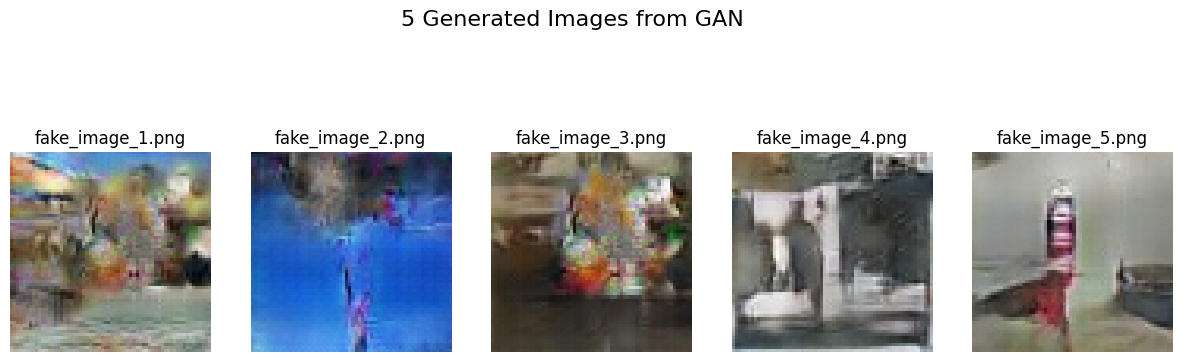

In [ ]:
# === STEP 6: Display the 5 Generated Images ===
import matplotlib.pyplot as plt
from PIL import Image
import os

generated_dir = "/content/generated_images"
generated_images = sorted([f for f in os.listdir(generated_dir) if f.endswith('.png')])

plt.figure(figsize=(15, 5))

for idx, img_name in enumerate(generated_images):
    img_path = os.path.join(generated_dir, img_name)
    img = Image.open(img_path)
    plt.subplot(1, 5, idx + 1)
    plt.imshow(img)
    plt.axis("off")
    plt.title(f"{img_name}")

plt.suptitle("5 Generated Images from GAN", fontsize=16)
plt.show()


In [ ]:
# The images are not clear enough. Randomly picking 5 images from https://storage.googleapis.com/openimages/web/download_v7.html

In [ ]:
# Create folder to save images
os.makedirs("/content/real_images", exist_ok=True)

In [ ]:
!wget https://storage.googleapis.com/cvdf-datasets/oid/open-images-dataset-train0.tsv -O train0.tsv


--2025-04-28 02:02:43--  https://storage.googleapis.com/cvdf-datasets/oid/open-images-dataset-train0.tsv
Resolving storage.googleapis.com (storage.googleapis.com)... 142.251.170.207, 173.194.174.207, 74.125.23.207, ...
Connecting to storage.googleapis.com (storage.googleapis.com)|142.251.170.207|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 95962971 (92M) [text/tab-separated-values]
Saving to: ‘train0.tsv’

train0.tsv          100%[===================>]  91.52M  24.3MB/s    in 4.8s    

2025-04-28 02:02:49 (19.0 MB/s) - ‘train0.tsv’ saved [95962971/95962971]



In [ ]:
import pandas as pd

# Read the TSV properly, skip the middle column
df = pd.read_csv("train0.tsv", sep="\t", skiprows=1, header=None, usecols=[0, 2], names=["url", "image_id"])

# Confirm
print(df.head())


                                                 url                  image_id
0  https://c7.staticflickr.com/6/5499/10245691204...  XKWUMkcNib71Ge6Yq1/0/g==
1  https://farm1.staticflickr.com/5615/1533586145...  CyvuYIfw90WAr8y0a1PaOw==
2  https://c7.staticflickr.com/8/7590/17048042861...  cFlLPftwE0e7PznqGLwxKA==
3  https://farm5.staticflickr.com/5582/1823300949...  bIoO16vdUB8MpG+Wbe1bxw==
4  https://farm6.staticflickr.com/4126/5145819744...  nauUgLObUcXqCUxuVabxbw==


In [ ]:
import pandas as pd
import os
import requests
import random

# Read TSV correctly
df = pd.read_csv("train0.tsv", sep="\t", skiprows=1, header=None, usecols=[0,2], names=["url", "image_id"])

# Make folder
save_dir = "/content/real_images"
os.makedirs(save_dir, exist_ok=True)

downloaded = 0
tried_indices = set()

while downloaded < 5:
    idx = random.choice(df.index)
    if idx in tried_indices:
        continue
    tried_indices.add(idx)

    row = df.loc[idx]
    img_url = row["url"]
    img_id = row["image_id"]

    # Safe filename
    safe_img_id = img_id.replace("/", "_").replace("+", "_").replace("=", "_")
    save_path = os.path.join(save_dir, f"{safe_img_id}.jpg")

    try:
        response = requests.get(img_url, timeout=10)
        if response.status_code == 200:
            with open(save_path, "wb") as f:
                f.write(response.content)
            downloaded += 1
            print(f"✅ Downloaded {downloaded}/5: {safe_img_id}.jpg")
        else:
            print(f"⚠️ Failed {safe_img_id}.jpg - Status {response.status_code}")
    except Exception as e:
        print(f"❌ Error downloading {safe_img_id}.jpg: {e}")

print(f"🎯 Finished downloading {downloaded} images!")


✅ Downloaded 1/5: HUYLH3ly2ZQF6ak6AazP5A__.jpg
✅ Downloaded 2/5: 46o5Bz1SQGeDvyvnonv1_w__.jpg
✅ Downloaded 3/5: nA1enwo36Oh5xBYHGSeU9Q__.jpg
✅ Downloaded 4/5: xbzm_81KocuVpOcOprPyhg__.jpg
✅ Downloaded 5/5: YbnaJmk_zik_UCHCChBgLA__.jpg
🎯 Finished downloading 5 images!


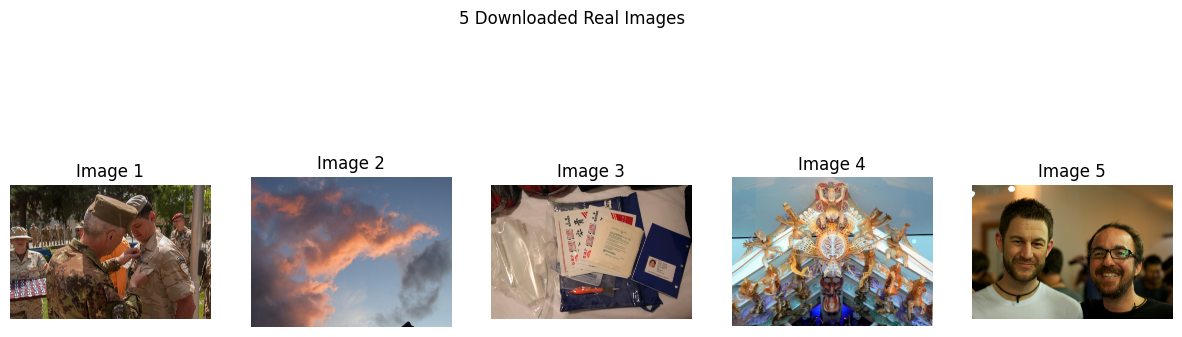

In [ ]:
import matplotlib.pyplot as plt
from PIL import Image
import os

# Set your image directory
save_dir = "/content/real_images"

# List the 5 downloaded images
image_files = sorted([f for f in os.listdir(save_dir) if f.endswith('.jpg')])

# Plot
plt.figure(figsize=(15, 5))
for idx, img_name in enumerate(image_files):
    img_path = os.path.join(save_dir, img_name)
    img = Image.open(img_path)

    plt.subplot(1, 5, idx + 1)
    plt.imshow(img)
    plt.axis("off")
    plt.title(f"Image {idx+1}")

plt.suptitle("5 Downloaded Real Images")
plt.show()


In [ ]:
# ====== Imports ======
import torch
from torchvision import models, transforms
from torchvision.transforms import functional as F
from transformers import BlipProcessor, BlipForConditionalGeneration
from PIL import Image
import matplotlib.pyplot as plt
import matplotlib.patches as patches
import os

In [ ]:
device = "cpu"

In [ ]:
# Load object detection model (Faster R-CNN)
faster_rcnn = models.detection.fasterrcnn_resnet50_fpn(pretrained=True)
faster_rcnn = faster_rcnn.eval().to(device)

In [ ]:
# Load Better Captioning Model (BLIP-Large)
processor = BlipProcessor.from_pretrained("Salesforce/blip-image-captioning-large")
blip_model = BlipForConditionalGeneration.from_pretrained("Salesforce/blip-image-captioning-large").to(device)

In [ ]:
# ====== Prepare images ======
img_dir = "/content/real_images"

# Pick only .jpg images safely
img_files = sorted([f for f in os.listdir(img_dir) if f.lower().endswith('.jpg')])[:5]

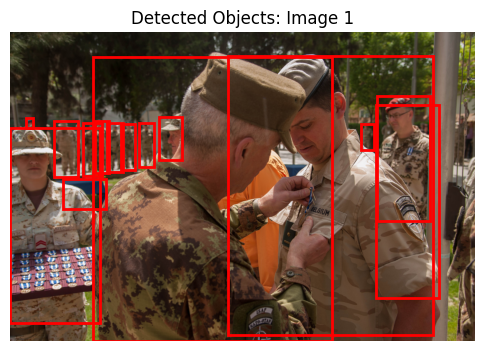

📝 Caption for Image 1: soldiers are standing around a man in uniform tying a tie


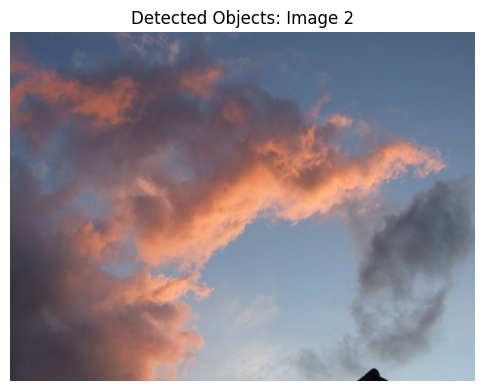

📝 Caption for Image 2: there is a plane flying in the sky with a pink cloud


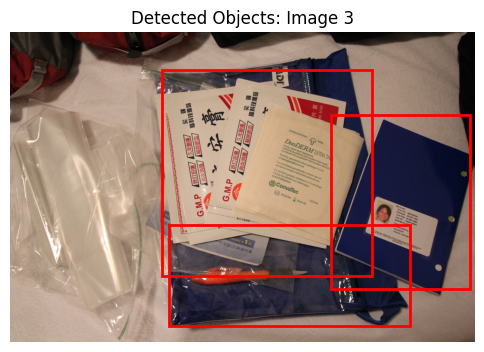

📝 Caption for Image 3: there are many items that are sitting on a table


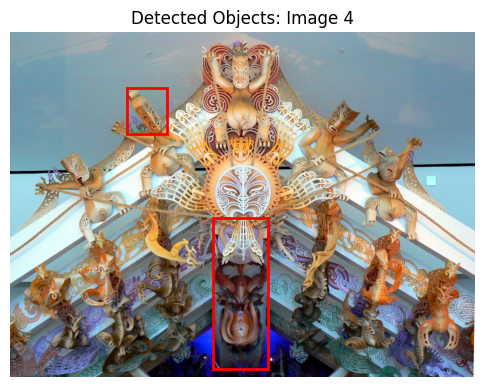

📝 Caption for Image 4: there is a statue of a woman with a headdress and a man with a beard


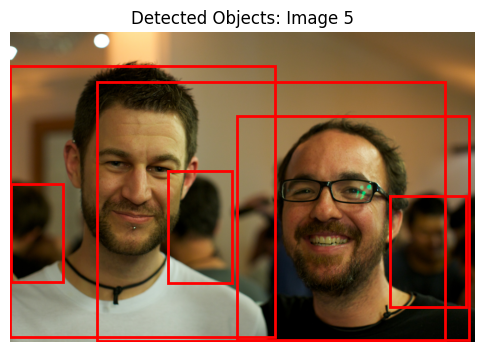

📝 Caption for Image 5: they are two men standing next to each other smiling for the camera


In [ ]:

# ====== Loop over each image ======
for idx, img_name in enumerate(img_files):
    img_path = os.path.join(img_dir, img_name)

    # Open the image
    img = Image.open(img_path).convert("RGB")

    # -------- Object Detection --------
    img_tensor = F.to_tensor(img).unsqueeze(0).to(device)

    with torch.no_grad():
        preds = faster_rcnn(img_tensor)[0]

    # Plot detections
    plt.figure(figsize=(6, 6))
    plt.imshow(img)
    ax = plt.gca()
    for box, score in zip(preds["boxes"], preds["scores"]):
        if score > 0.5:
            x1, y1, x2, y2 = box.cpu()
            rect = patches.Rectangle((x1, y1), x2-x1, y2-y1, linewidth=2, edgecolor="red", facecolor="none")
            ax.add_patch(rect)
    plt.axis("off")
    plt.title(f"Detected Objects: Image {idx+1}")
    plt.show()

    # -------- Captioning (Zero Shot) --------
    inputs = processor(images=img, return_tensors="pt").to(device)
    outputs = blip_model.generate(**inputs, max_length=30)
    caption = processor.decode(outputs[0], skip_special_tokens=True)

    print(f"📝 Caption for Image {idx+1}: {caption}")
